# Two-point Boundary Value Problem
## Linear Quadratic Regulator

**Goal:**  (Notes 5-14)
$$\min J = \frac{1}{2} \int_{t_0}^{t_f} \left[v^2(t)+u^2(t)\right] dt$$
with dynamics
$
\dot v = v + u
$

- Set $\mathbf{x}=[x_1 ~~  x_2]^T=[v ~~u]^T$, so problem becomes
$$\min J = \frac{1}{2}\int_{t_0}^{t_f} \mathbf{x}^T(t)\mathbf{x}(t) dt, \\ 
\dot x_1(t) = x_1(t) + x_2(t)
$$

- Thus constraint differntial equation is $\mathbf{a}(\mathbf{x},\mathbf{\dot x})=\dot x_1(t) - x_1(t) - x_2(t)$ and using multiplier $p(t)$ we get
$$
g_a(\mathbf{x},\mathbf{\dot x})= \frac{1}{2} \mathbf{x}^T(t)\mathbf{x}(t) + p(t)(\dot x_1(t) - x_1(t) - x_2(t))
$$

- Optimal solution must satisfy (there are 3 necessary conditions) $x_2(t)\equiv u(t) = p(t)$ and that
\begin{eqnarray}
\dot x_1(t) &=& x_1(t) + x_2(t) = x_1(t) + p(t)\\
\dot p(t) &=& x_1(t) - p(t)
\end{eqnarray}
where $x_1(t_0)=v(t_0)$ given and, e.g., $x_1(t_f)=v(t_f)$ are known.

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/ecrbitp4tig1jq6/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

try:
    from pyomo.environ import *
except:
    %pip install pyomo
from pyomo.environ import *
from pyomo.dae import *


Running Python: 3.8.16


In [6]:
def my_solve(tf = 6,x0 = 4,xf = -2): # create a model object

    m = ConcreteModel()

    # define the independent variable
    m.t = ContinuousSet(bounds=(0,tf))

    # define the dependent variables
    m.x1 = Var(m.t)
    m.x2 = Var(m.t)
    m.p = Var(m.t)

    # define derivatives
    m.x1_dot = DerivativeVar(m.x1, wrt=m.t)
    m.x2_dot = DerivativeVar(m.x2, wrt=m.t)
    m.p_dot = DerivativeVar(m.p, wrt=m.t)

    m.ode_x1 = Constraint(m.t, rule=lambda m, t: m.x1_dot[t] == m.x1[t]+m.x2[t])
    m.ode_p = Constraint(m.t, rule=lambda m, t: m.p_dot[t] == m.x1[t]-m.p[t])

    # initial conditions
    m.pc = ConstraintList()
    m.pc.add(m.x1[0]==x0)
    m.pc.add(m.x1[tf]==xf)

    def _con(m, t):
          return m.p[t]==m.x2[t]
    m.con = Constraint(m.t, rule=_con)

    # transform and solve
    TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=300)
    solver = SolverFactory('ipopt')
    solver.options['max_iter']= 10000 #number of iterations you wish
    solver.solve(m)#.write()
    return m

## Example 1: Control penalizes $x(t) \neq 0$ **and** the control effort to make $x(t)$ small 

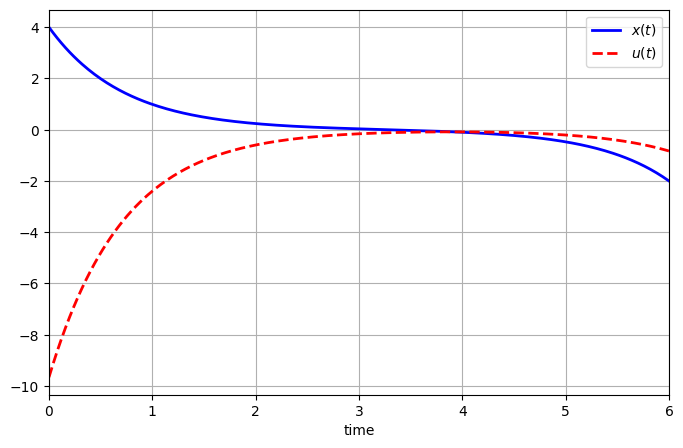

In [8]:
tf = 6 # Final time
x0 = 4 # Initial State
xf = -2 # Final State

m = my_solve(tf,x0,xf)

# access the results
tt = np.array([t for t in m.t])
x1 = np.array([m.x1[t]() for t in m.t])
u = np.array([m.x2[t]() for t in m.t])
p = np.array([m.p[t]() for t in m.t])

plt.figure(figsize=(8,5))
plt.plot(tt, x1, 'b-',label=r'$x(t)$')
#plt.plot(tt, p, ls='-')
plt.plot(tt, u, 'r--',label=r'$u(t)$')
plt.xlabel('time')
plt.xlim([0, tf])
plt.legend()
plt.grid(True)

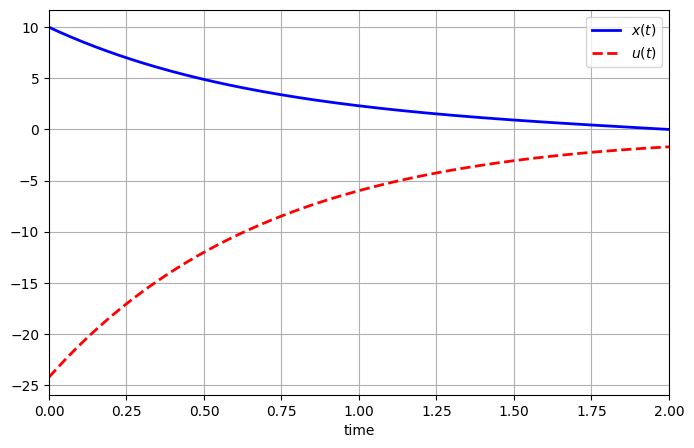

In [9]:
tf = 2 # Final time
x0 = 10 # Initial State
xf = 0 # Final State

m = my_solve(tf,x0,xf)

# access the results
tt = np.array([t for t in m.t])
x1 = np.array([m.x1[t]() for t in m.t])
u = np.array([m.x2[t]() for t in m.t])
p = np.array([m.p[t]() for t in m.t])

plt.figure(figsize=(8,5))
plt.plot(tt, x1, 'b-',label=r'$x(t)$')
#plt.plot(tt, p, ls='-')
plt.plot(tt, u, 'r--',label=r'$u(t)$')
plt.xlabel('time')
plt.xlim([0, tf])
plt.legend()
plt.grid(True)

## Example 2: Control penalizes $x(t) \neq 0$ **and** the control effort to make $x(t)$ small 
### Note what happens when $t_f$ is large when $x_f \neq 0$

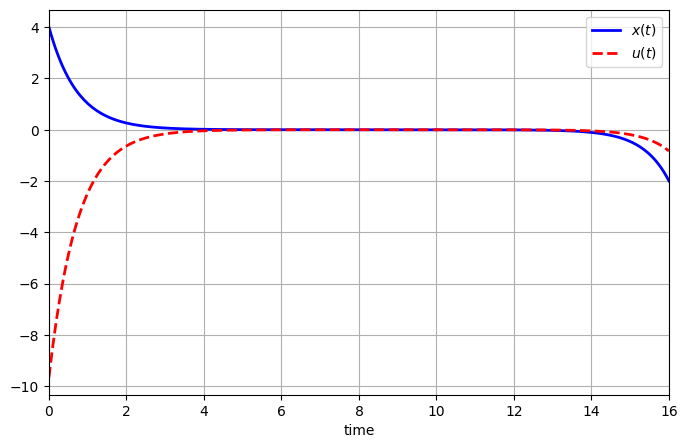

In [10]:
tf = 16 # Final time
x0 = 4 # Initial State
xf = -2 # Final State

m = my_solve(tf,x0,xf)

# access the results
tt = np.array([t for t in m.t])
x1 = np.array([m.x1[t]() for t in m.t])
u = np.array([m.x2[t]() for t in m.t])
p = np.array([m.p[t]() for t in m.t])

plt.figure(figsize=(8,5))
plt.plot(tt, x1, 'b-',label=r'$x(t)$')
#plt.plot(tt, p, ls='-')
plt.plot(tt, u, 'r--',label=r'$u(t)$')
plt.xlabel('time')
plt.xlim([0, tf])
plt.legend()
plt.grid(True)